In [1]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
warnings.simplefilter('ignore')

countryName = 'US'

nfeatures = 1

nDaysMin = 3
k = 7

nValid = 10
nTest = 10

In [2]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFile = 'confirmed_july.csv'
deathsFile = 'deaths_july.csv'
recoveredFile = 'recovered_july.csv'

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # input and output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))

def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [5]:
# All three csvs for this countru
def getCountryDict(countryName):
    countryDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryDict

In [6]:
# get time series data for country
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFile)
covidFrDict['deaths'] = pd.read_csv(deathsFile)
covidFrDict['recovered'] = pd.read_csv(recoveredFile)

countryDict = getCountryDict(countryName)

# List of dates
colNamesList = list(countryDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))
type(yTrain)
XTrainList.shape
yTest
dateList 
covidFrDict['confirmed']
type(countryDict)

Total size of data points for LSTM: 137
Size of training set: 117
Size of validation set: 10
Size of test set: 10


dict

In [7]:
# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nfeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nfeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nfeatures))

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

neurons = 100 # number of neurones
nfeatures = 1  # number of features

#getting the best MAPE to use for model fitting
bestValidMAPE = 100 #100 validation for selecting the best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
   
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed

print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
   

0 0.8835397636160901
Updating best MAPE to 0.8835397636160901...
Updating best seed to 0...
1 3.863818759985725
2 1.519249136897072
3 1.4461742875741754
4 2.722922113317927
5 0.35001229932502936
Updating best MAPE to 0.35001229932502936...
Updating best seed to 5...
6 99.98777465715102
7 13.622952705753766
8 4.65159211670409
9 3.1744333162639076
10 3.7068948984375027
11 0.3105106161250056
Updating best MAPE to 0.3105106161250056...
Updating best seed to 11...
12 0.7946900884656907
13 2.1590344779192945
14 99.9903963073417
15 2.3561277933507827
16 1.7025164006478486
17 1.1610784090418422
18 1.0873696327988736
19 99.98759479257062
20 99.98789772928987
21 1.5953971076674198
22 99.98741255860394
23 3.4199245146157233
24 0.6275024215143841
25 99.9874262262728
26 3.3824412599035125
27 99.9874823098406
28 2.9858169930154115
29 1.857580298821766
30 0.6435023973485808
31 2.1690706831602937
32 99.98782803922997
33 1.1707699110503331
34 3.720122231070103
35 5.173871825590276
36 0.6390297283683359

In [9]:
# define model
model = Sequential()
model.add(LSTM(neurons, activation='relu', input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_100 (LSTM)              (None, 100)               40800     
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


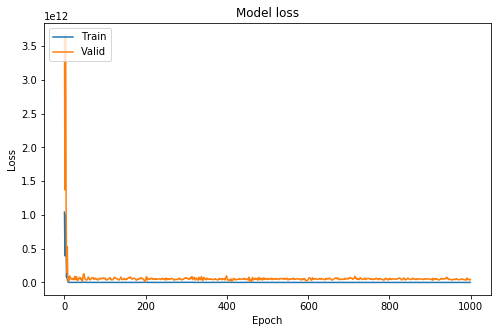

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [11]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredVanilla = yPredListList 
#Test MAPE: 0.04888603859343367
#Test MdSA: 0.05161317825322761
#Test MSE: 203428.25474330358
#Test RMSE: 451.03021488953885

Test MAPE: 0.5682699856360909
Test MdSA: 0.5784749446231118
Test MSE: 970889716.2517858
Test RMSE: 31159.103264564368


In [14]:
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
    model.add(LSTM(neurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nfeatures)))
model.add(LSTM(neurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 64.10075229056032
Updating best MAPE to 64.10075229056032...
Updating best seed to 0...
1 62.64445246235495
Updating best MAPE to 62.64445246235495...
Updating best seed to 1...
2 65.45621153531224
3 63.52274757366451
4 0.492240650942267
Updating best MAPE to 0.492240650942267...
Updating best seed to 4...
5 64.21740328379678
6 65.16160493349722
7 6.049912798236957
8 2.6724241150318133
9 64.0410744570047
10 63.86880264102485
11 1.3822677014627092
12 64.68279015349893
13 2.5579166761955605
14 2.74288824255369
15 0.8091042023555197
16 2.1037713009624377
17 1.69015388273751
18 0.9613601185929369
19 7.215138805789456
20 0.3433433507254334
Updating best MAPE to 0.3433433507254334...
Updating best seed to 20...
21 63.85888682930436
22 65.4331502130678
23 1.4272112120299043
24 1.2189073238671289
25 10.787991621988272
26 2.5567389150195794
27 1.274420686606989
28 64.16062863310636
29 3.8566214878741696
30 3.278858253901346
31 1.3701770884521924
32 1.9278822443051258
33 2.6474287945508905
34 

In [15]:
model.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_301 (LSTM)              (None, 3, 50)             10400     
_________________________________________________________________
lstm_302 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


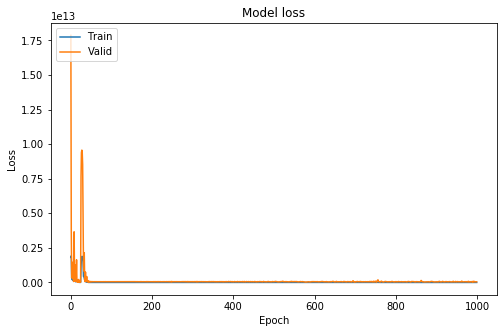

In [16]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [17]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredStacked = yPredListList
#Test MAPE: 0.6526826190135445
#Test MdSA: 0.6277125989801505
#Test MSE: 37158961.193359375
#Test RMSE: 6095.815055704969

Test MAPE: 0.4599537981572653
Test MdSA: 0.4473094887633192
Test MSE: 540162740.1964285
Test RMSE: 23241.401424966363


# Bi-directional LSTM

In [18]:
# define model
neurons = 50
nfeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(nDaysMin, nfeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 0.7486884333707
Updating best MAPE to 0.7486884333707...
Updating best seed to 0...
1 1.302434516868363
2 1.3169397425198532
3 0.9959957289624661
4 0.3620430919187429
Updating best MAPE to 0.3620430919187429...
Updating best seed to 4...
5 0.8562678484776939
6 2.481715468539363
7 1.4056750711898351
8 1.1950033994944036
9 4.920297755486488
10 4.2330107742138035
11 2.982974720949423
12 4.718453102369218
13 1.1891492275442033
14 0.8853941349463071
15 3.3794279550178428
16 2.9200222898437964
17 7.288274294074865
18 4.14032976510308
19 3.2647395226679947
20 4.31702986625833
21 11.603366825436748
22 1.7278783539043119
23 1.5326307895388713
24 0.6308441256134387
25 0.83771578673928
26 1.9747884063308077
27 2.543317191922436
28 1.3012964282036072
29 10.512527947960669
30 0.2914509946999217
Updating best MAPE to 0.2914509946999217...
Updating best seed to 30...
31 0.6660709717703515
32 5.9657038914420735
33 1.7995120222333334
34 99.99399231180948
35 1.2203203608325701
36 99.99624428384462
37 

In [19]:
model.summary()

Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_100 (Bidirecti (None, 100)               20800     
_________________________________________________________________
dense_302 (Dense)            (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


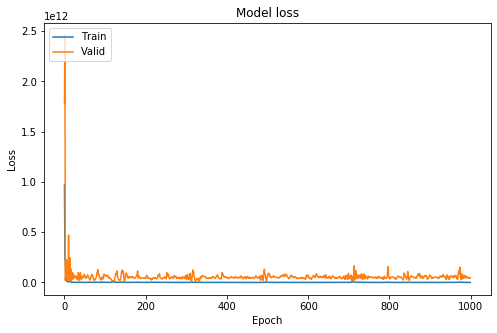

In [20]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [21]:
history = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=30, verbose=1)

Epoch 1/30
4/4 [==============================] - 0s 19ms/step - loss: 175256416.0000 - val_loss: 51713204224.0000
Epoch 2/30
4/4 [==============================] - 0s 20ms/step - loss: 206423648.0000 - val_loss: 45337227264.0000
Epoch 3/30
4/4 [==============================] - 0s 20ms/step - loss: 223094000.0000 - val_loss: 42014408704.0000
Epoch 4/30
4/4 [==============================] - 0s 20ms/step - loss: 204619008.0000 - val_loss: 41866629120.0000
Epoch 5/30
4/4 [==============================] - 0s 27ms/step - loss: 219453296.0000 - val_loss: 41535995904.0000
Epoch 6/30
4/4 [==============================] - 0s 23ms/step - loss: 270903520.0000 - val_loss: 43544432640.0000
Epoch 7/30
4/4 [==============================] - 0s 23ms/step - loss: 259145968.0000 - val_loss: 45048422400.0000
Epoch 8/30
4/4 [==============================] - 0s 23ms/step - loss: 260430224.0000 - val_loss: 60176728064.0000
Epoch 9/30
4/4 [==============================] - 0s 26ms/step - loss: 256484320

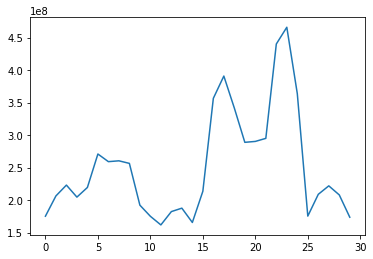

In [22]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.show()

In [23]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredBidirectional = yPredListList
#Test MAPE: 5.3922052299956595
#Test MdSA: 5.396834387761436
#Test MSE: 56670526632.16428
#Test RMSE: 238055.72169591783

Test MAPE: 1.3115236058854536
Test MdSA: 1.3762808178734969
Test MSE: 4099395458.8776784
Test RMSE: 64026.521527236495


In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

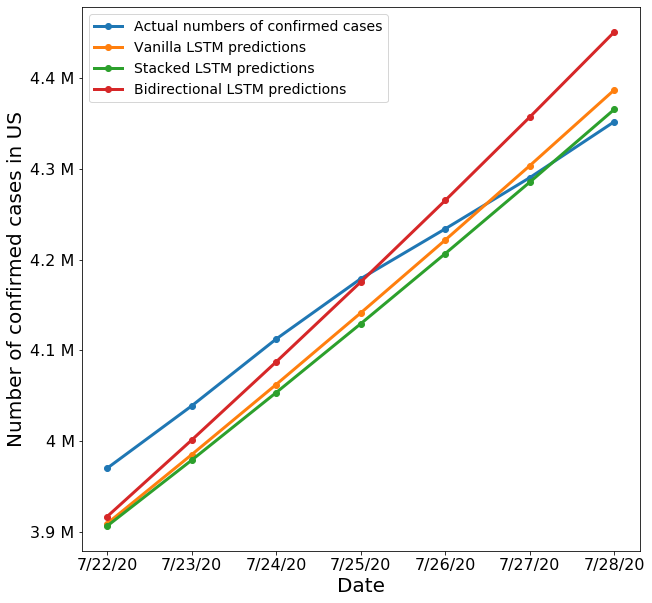

In [25]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in US', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_3days_k7_new', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [26]:
datesForPlottingList
groundTruthList
#yPredVanilla[-1]
#yPredStacked[-1]
#yPredBidirectional[-1]

[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

In [27]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)
#Test RMSE: 474686.0857197107
#Test RMSE: 482631.6970954928
#Test RMSE: 450396.2191884893

Test RMSE: 474686.0857197107
Test RMSE: 482631.6970954928
Test RMSE: 450396.2191884893


In [28]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)
#Test RMSE: 41531.148532607425
#Test RMSE: 45551.58776792057
#Test RMSE: 53594.45385801861

Test RMSE: 41531.148532607425
Test RMSE: 45551.58776792057
Test RMSE: 53594.45385801861


In [29]:
groundTruthList
#[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

[3970121, 4038816, 4112531, 4178970, 4233923, 4290337, 4351997]

In [30]:
yPredVanilla[-1]
#[3909247.5, 3985107.5, 4062437.2, 4141264.5, 4221619.0, 4303530.0, 4387027.5]

[3909247.5, 3985107.5, 4062437.2, 4141264.5, 4221619.0, 4303530.0, 4387027.5]

In [31]:
yPredStacked[-1]
#[3906455.5, 3979021.5, 4053525.0, 4129358.5, 4206646.5, 4285373.0, 4365572.5]

[3906455.5, 3979021.5, 4053525.0, 4129358.5, 4206646.5, 4285373.0, 4365572.5]

In [32]:
 yPredBidirectional[-1]
    #[3916895.0, 4001185.8, 4087339.8, 4175345.5, 4265241.5, 4357069.0, 4450869.5]

[3916895.0, 4001185.8, 4087339.8, 4175345.5, 4265241.5, 4357069.0, 4450869.5]